# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## ОГЛАВЛЕНИЕ

[Описание проекта](#description)

[Цель проекта](#purpose)

[1. Загрузка и подготовка данных](#1)

- [1.1 Вывод по первичному анализу данных](#1.1)

[2. Обучение и проверка модели](#2)

[3. Подготовка к расчёту прибыли](#3)

[4. Расчёт прибыли и рисков ](#4)

[Выводы и предложения](#5)

<a id='description'></a>
## Описание проекта

У компании ГлавРосГосНефть имеются данные по пробам нефти из скважин в трех разных регионах. Необходимо предсказать объемы запасов в этих скважинах, отобрать скважины с наиболее высокими оценками значений и регион с максимальной суммарной прибылью по всем отобранным скажинам. Также необходимо сделать расчет прибыли и рисков.  

**Описание данных:**  
•	***id*** — уникальный идентификатор скважины;  
•	***f0, f1, f2*** — три признака точек (неважно, что они означают, но сами признаки значимы);  
•	***product*** — объём запасов в скважине (тыс. баррелей).  

**Условия задачи:**  
•	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
•	Бюджет на разработку скважин в регионе — 10 млрд рублей.  
•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
•	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

<a id='purpose'></a>
## Цель проекта

Необходимо выбрать один из трех регионов, в котором компании будет наиболее выгодно разрабатывать нефтяные скважины. Для этого исследуем качественные показатели скважин в каждом из регионов, потенциальную прибыль и риск убытков.  

Чтобы это реализовать, требуется построить модель, прогнозирующую наиболее "продуктивные", т.е. скважины с самыми высокими оценками значений. А затем с помощью техники Bootstrap необходимо определить распределение прибыли и вероятность убытков. На основании этого исследования определить наиболее перспективный регион для разработки скважин.

<a id='1'></a>
## Загрузка и подготовка данных

In [1]:
#Нужно обновить seaborn (текущая версия не строила гистограммы)
!pip install --upgrade seaborn


Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


In [2]:
#Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
#Прочитаем датасеты
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')


<a id='1.1'></a>
### Анализ общей информации

In [4]:
#Заведем словарь с именами датасетов для дальнейшего использования в циклах
datasets = [data_0, data_1, data_2]

In [5]:
#Выведем первые строки таблиц для знакомства с данными
for data in datasets:
    display(data.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
#Выведем общую информацию для оценки количества пропусков и типов данных
for data in datasets:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [7]:
#Проверим наличие грубых дубликатов
for data in datasets:
    display(data.duplicated().sum())

0

0

0

In [8]:
#Удалим колонку id как ненужную для моделей
for data in datasets:
    data = data.drop('id', axis='columns')

#Перезапишем словарь с новыми данными
datasets = [data_0, data_1, data_2]

In [9]:
#Посмотрим описательную статистику
for data in datasets:
    display(data.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


__Вывод.__ Видим, что распределение значений признаков f0, f1, f2 похоже на нормальное (медианы и средние близки друг к другу) во всех трех датасетах. Хотя сами значения квартилей и мин/макс точек различаются между этими регионами в разы. Распределение по объемам продукта у первого и третьего региона тоже близки к нормальному, у второго - есть смещение вправо (медиана меньше среднего)
В третьем регионе самые высокие показатели средних и медианных объемов нефти в скважинах, лучший максимум, плюс, по каждому из квартилей он тоже кажется наиболее продуктивным из всех. 

In [10]:
#Создадим функцию для вывода гистограмм по каждому признаку в сравнении по регионам
def hist(column):
    size = (-40, 200)
    plt.figure(figsize=(12,8))
    plt.title('Распределение признака {} по регионам'.format(column), fontsize=22)
    plt.xlabel('Значение признака {}'.format(column), fontsize=16)
    plt.ylabel('Количество значений', fontsize=16)
    sns.histplot(data=data_0, x = data_0[column], stat="density", label = '1', element="step", fill=False)
    sns.histplot(data=data_1, x = data_1[column], stat="density", label = '2', element="step", fill=False)
    sns.histplot(data=data_2, x = data_2[column], stat="density", label = '3', element="step", fill=False)
    plt.legend(title='Регионы')

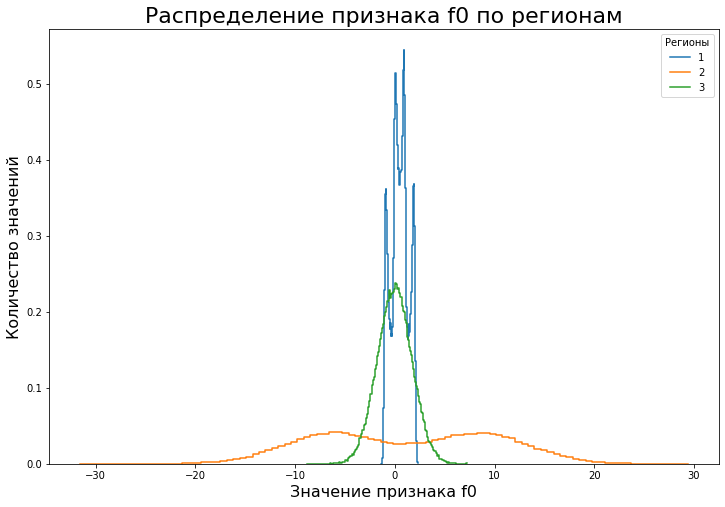

In [11]:
#Сравнительный график с признаком f0
hist('f0')

Гистограмма показывает, что распределения значений признака f0 для регионов 1 и 3 действительно похожи на нормальное, причем 75% значений лежат в районе единицы. У второго региона имеется два небольших плавных пика, но при этом гораздо больший разброс значений. 

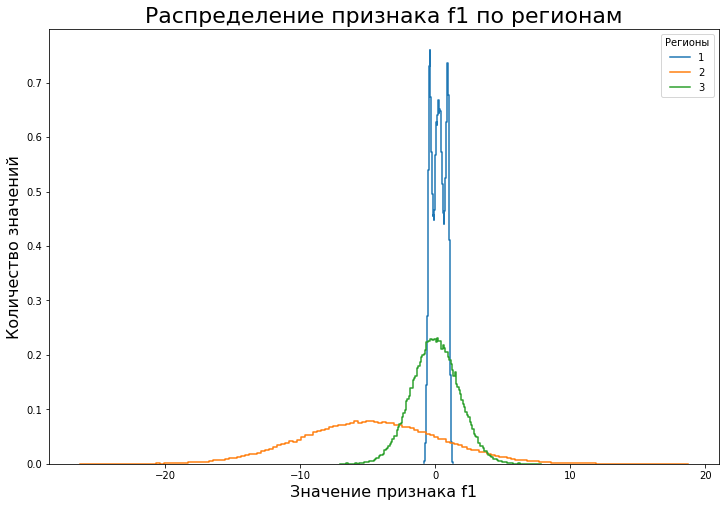

In [12]:
#Сравнительный график с признаком f1
hist('f1')

Здесь можно отметить, что у региона 1 признак f1 имеет самый малый разброс значений, с несколькими резкими пиками. А у региона 2 снова самый большой разброс и самый плавный график.

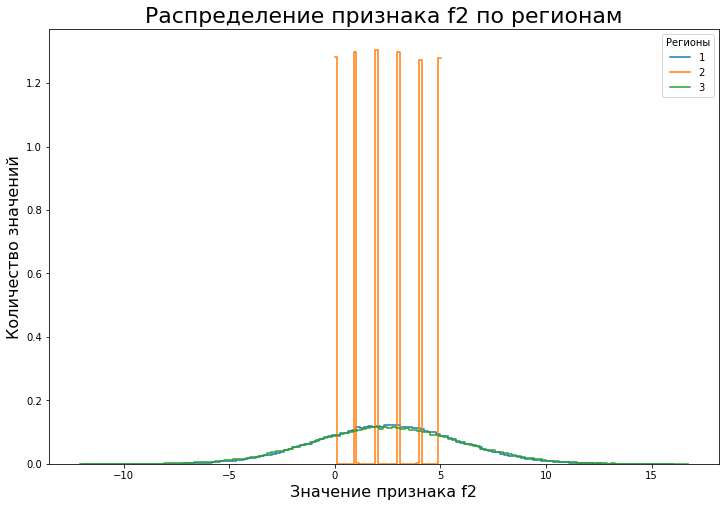

In [13]:
#Сравнительный график с признаком f2
hist('f2')

Гистограммы признака f2 для регионов 1 и 3 практически одинаковы и имеют вид нормального распределения. Регион 2 снова отличился - 6 резкими пиками с практически одинаковым количеством значений по ним, получается, что в этом регионе для признака f2 характерно словно бы несколько определенных коэффициентов. 

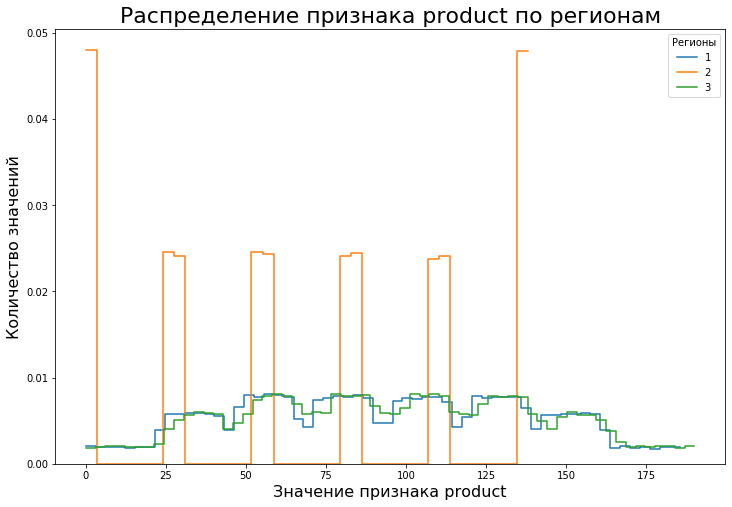

In [14]:
#Сравнительный график с признаком product (объем запасов в скважине)
hist('product')

Распределение объемов запасов нефти по трем регионам кажется логически связанным с предыдущей гистограммой (про признак f2). По объему продукта регионы 1 и 3 имеют относительно плавные графики с незначительными пиками.
Для региона 2 характерно наибольшее количество скважин с нулевыми и околонулевыми запасами, но при этом почти столько же - с максимальными запасами по региону. Остальные скважины региона 2 делятся строго на 4 группы с небольшими колебаниями значений внутри каждой.  
Но, несмотря на внешнее различие гистограмм, можно сказать, что в каждом из трех регионов имеются примерно равные (внутри региона) группы скважин с определенным потенциалом. Различие в том, что в регионах 1 и 2 минимальные и максимальные объемы - в меньшинстве, а во 2-м регионе, наоборот, много скважин с почти нулевыми запасами и много с близкими к региональному максимуму.

In [15]:
#Посмотрим корреляцию признаков
for data in datasets:
    display(data.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


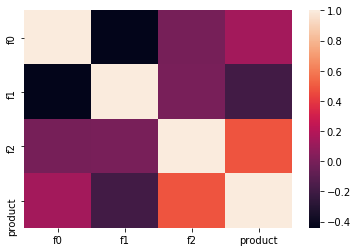

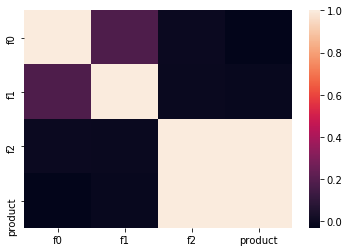

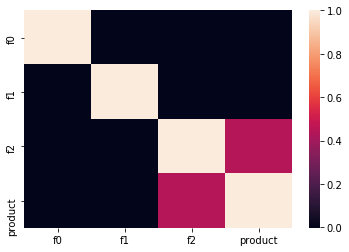

In [16]:
#Выведем матрицы корреляции признаков по каждой таблице
for data in datasets:
    sns.heatmap(data.corr())
    plt.show()

__Вывод.__ Видим незначительную отрицательную корреляцию между признаками f0 и f1 в первом регионе (во втором - совсем небольшая положительная, в третьем - практически нулевая). Между остальными признаками f зависимости практически отсутсвует во всех регионах.  
Наиболее сильная зависимость наблюдается между признаком f2 и продуктом (объем нефти в скважинах): у второго региона корреляция почти равна единице, у двух других меньшая зависимость, но тоже положительная корреляция - коэффициент 0.45 и 0.48. В первом регионе также наблюдается небольшая (меньше 0.2) корреляция продукта и признаков f0 и f1, но в двух других этого нет - коээфициенты околонулевые.

<a id='1.1'></a>
### Вывод по первичному анализу

1. Перед нами 3 датасета по 5 колонок и 100 000 строк в каждом. Без пропусков, без дубликатов, типы данных корректные.
2. Так как описание каждого из признаков отсутствует, мы не можем дать экспертную оценку корректности данных (например, возможны ли отрицательные значения), поэтому будем считать их все пригодными для дальнейшей работы
3. Столбец id не нужен для работы модели, удалили его
4. Обзор статистики показывает, что регион 3 выглядит наиболее продуктивным из всех.
5. Распределение почти всех признаков близко к нормальному. Нетипичная картина только в столбцах f2 и product у региона №2 - графики не плавные, а имеют несколько изолированных пиков, словно значения уже отнесены к каким-то узким группам, с интервалами между ними. Это наводит на мысль о наличии предварительной обработки данных по региону 2 (т.е. как будто мы получили не чистую статистику, а уже разбитые на некие крупные группы и подогнанные под них показатели), но придется использовать как есть.
6. Анализ корреляции показывает, что четкая зависимость наблюдается только между признаком f2 и объемом продукта, причем у региона 2 коэффициент корреляции практически равен единице (подозрительно большое значение)

<a id='2'></a>
## Обучение и проверка модели

<a id='2.1'></a>
### Разбивка на выборки

Для каждого региона требуется выделить обучающую и валидационную выборки в пропорциях 75/25.
Целевым признаком здесь является столбец product. Это количественный признак, поэтому будем решать задачу регресии.

In [17]:
#Отделим целевой признак от остальных и поделим данные на две выборки
def sample(data):
    target = data['product']
    features = data.drop(['product', 'id'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    scaler = StandardScaler() #добавим масштабирование признаков
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    return target, features, features_train, features_valid, target_train, target_valid


target_0, features_0, features_train_0, features_valid_0, target_train_0, target_valid_0 = sample(data_0)
target_1, features_1, features_train_1, features_valid_1, target_train_1, target_valid_1 = sample(data_1)
target_2, features_2, features_train_2, features_valid_2, target_train_2, target_valid_2 = sample(data_2) 

<a id='2.3'></a>
### Обучение моделей

In [18]:
#Модель для региона 1
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predicted_valid_0 = model_0.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predicted_valid_0)**0.5
predictions_0 = pd.Series(predicted_valid_0, index=target_valid_0.index)

#Константная модель для региона 1
predicted_valid_const_0 = pd.Series(target_train_0.mean(), index=target_valid_0.index)
rmse_const_0 = mean_squared_error(target_valid_0, predicted_valid_const_0)**0.5

print('RMSE региона 1: {:.2f}'.format(rmse_0))
print('RMSE константной модели региона 1: {:.2f}'.format(rmse_const_0))
print('Средний запас предсказанного сырья региона 1: {:.2f}'.format(predicted_valid_0.mean()), 'тыс. баррелей')

RMSE региона 1: 37.58
RMSE константной модели региона 1: 44.29
Средний запас предсказанного сырья региона 1: 92.59 тыс. баррелей


In [19]:
#Модель для региона 2
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predicted_valid_1 = model_1.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predicted_valid_1)**0.5
predictions_1 = pd.Series(predicted_valid_1, index=target_valid_1.index)

#Константная модель для региона 2
predicted_valid_const_1 = pd.Series(target_train_1.mean(), index=target_valid_1.index)
rmse_const_1 = mean_squared_error(target_valid_1, predicted_valid_const_1)**0.5

print('RMSE региона 2: {:.2f}'.format(rmse_1))
print('RMSE константной модели региона 2: {:.2f}'.format(rmse_const_1))
print('Средний запас предсказанного сырья региона 1: {:.2f}'.format(predicted_valid_1.mean()), 'тыс. баррелей')

RMSE региона 2: 0.89
RMSE константной модели региона 2: 46.02
Средний запас предсказанного сырья региона 1: 68.73 тыс. баррелей


In [20]:
#Модель для региона 3
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predicted_valid_2 = model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predicted_valid_2)**0.5
predictions_2 = pd.Series(predicted_valid_2, index=target_valid_2.index)

#Константная модель для региона 3
predicted_valid_const_2 = pd.Series(target_train_2.mean(), index=target_valid_2.index)
rmse_const_2 = mean_squared_error(target_valid_2, predicted_valid_const_2)**0.5

print('RMSE региона 1: {:.2f}'.format(rmse_2))
print('RMSE константной модели региона 3: {:.2f}'.format(rmse_const_2))
print('Средний запас предсказанного сырья региона 1: {:.2f}'.format(predicted_valid_2.mean()), 'тыс. баррелей')

RMSE региона 1: 40.03
RMSE константной модели региона 3: 44.90
Средний запас предсказанного сырья региона 1: 94.97 тыс. баррелей


In [21]:
#Сохраним предсказания и правильные ответы на валидационной выборке
def save_preds(predicted_valid, target_valid):
    pred_target = pd.DataFrame(index=target_valid.index)
    pred_target['predictions'] = predicted_valid
    pred_target['target'] = target_valid
    return pred_target
    
pred_target_0 = save_preds(predicted_valid_0, target_valid_0)
pred_target_1 = save_preds(predicted_valid_1, target_valid_1)
pred_target_2 = save_preds(predicted_valid_2, target_valid_2) 

print(pred_target_0.head())
print(pred_target_1.head())
print(pred_target_2.head())

       predictions      target
71751    95.894952   10.038645
80493    77.572583  114.551489
2655     77.892640  132.603635
53233    90.175134  169.072125
91141    70.510088  122.325180
       predictions     target
71751    82.663314  80.859783
80493    54.431786  53.906522
2655     29.748760  30.132364
53233    53.552133  53.906522
91141     1.243856   0.000000
       predictions      target
71751    93.599633   61.212375
80493    75.105159   41.850118
2655     90.066809   57.776581
53233   105.162375  100.053761
91141   115.303310  109.897122


Лучшее значение RMSE = 0.89 (минимальное) мы получили для второго региона, у двух других регионов RMSE немногим ниже значений той же метрики для константных моделей. При этом для второго региона предсказаны самые низкие из трех средние запасы сырья (68.73 тыс. баррелей).  
Самые высокие средние запасы сырья (94.97 тыс. баррелей) предсказаны для третьего региона и здесь же худшая метрика RMSE. У первого региона средние предсказанные запасы чуть ниже (92.59 тыс. баррелей), но при этом немного лучше RMSE.  
Получается, что в регионах, для которых предсказаны бОльшие запасы сырья, выше и вероятность ошибки предсказания.

<a id='3'></a>
## Подготовка к расчёту прибыли

In [22]:
#Сохраним в переменные все ключевые значения для расчетов
dev_wells = 200 #количество скважин, которое предполагается разрабатывать
budget = 10000000000 #бюджет на разработку скважин в регионе
revenue_barrel = 450000 #доход с одной единицы продукта (с тысячи баррелей)

#Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины
sufficient_volume = budget/dev_wells/revenue_barrel

print('Достаточный объем сырья для безубыточной разработки новой скважины: {:.2f}'.format(sufficient_volume), 'тыс. баррелей')

Достаточный объем сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


In [23]:
#Добавим значения расчетного дохода в таблицы с предсказаниями и правильными ответами
def append_profit(pred_target):
    pred_target['profit'] = pred_target['target'] * revenue_barrel
    return pred_target

pred_target_0 = append_profit(pred_target_0)
pred_target_1 = append_profit(pred_target_1)
pred_target_2 = append_profit(pred_target_2)

По результатам предсказаний объемов добычи в предыдущем пункте ни один из регионов не показал среднего значения запасов сырья, достаточного для безубыточной разработки. Максимально приблизился к расчетному значению безубыточности третий регион (средние предсказанные запасы - 94.97 тыс. баррелей), однако это все равно на 16 тыс. баррелей ниже, чем необходимо для работы "в ноль".  
Таким образом, мы видим, что для получения прибыли от нефтедобычи, нельзя взять "первые попавшиеся" скважины. Необходимо разрабатывать такие, где предсказаны наиболее высокие объемы добычи.

<a id='4'></a>
## Расчёт прибыли и рисков 

In [27]:
#Напишем функцию для расчета суммарной прибыли по 200 лучшим (с наибольшими предсказанными запасами) шахтам
def revenue(pred_target):
    preds_sorted = pred_target['predictions'].sort_values(ascending=False)
    selected = pred_target['target'][preds_sorted.index][:200]
    revenue = revenue_barrel * selected.sum()
    profit = revenue - budget
    return profit

profit_0 = revenue(pred_target_0)
profit_1 = revenue(pred_target_1)
profit_2 = revenue(pred_target_2)


print("Регион 1")
print('Суммарная прибыль с 200 лучших скважин: {:.3f}'.format(profit_0/1000000000), 'млрд руб.')
print('Целевое значение объема сырья с 200 лучших скважин: {:.1f}'.format((pred_target_0.sort_values(by='predictions', ascending=False)[:200])['target'].sum()), 'тыс. баррелей')
print()
print("Регион 2")
print('Суммарная прибыль с 200 лучших скважин: {:.3f}'.format(profit_1/1000000000), 'млрд руб.')
print('Целевое значение объема сырья с 200 лучших скважин: {:.1f}'.format((pred_target_1.sort_values(by='predictions', ascending=False)[:200])['target'].sum()), 'тыс. баррелей')
print()
print("Регион 3")
print('Суммарная прибыль с 200 лучших скважин: {:.3f}'.format(profit_2/1000000000), 'млрд руб.')
print('Целевое значение объема сырья с 200 лучших скважин: {:.1f}'.format((pred_target_2.sort_values(by='predictions', ascending=False)[:200])['target'].sum()), 'тыс. баррелей')


Регион 1
Суммарная прибыль с 200 лучших скважин: 3.321 млрд руб.
Целевое значение объема сырья с 200 лучших скважин: 29601.8 тыс. баррелей

Регион 2
Суммарная прибыль с 200 лучших скважин: 2.415 млрд руб.
Целевое значение объема сырья с 200 лучших скважин: 27589.1 тыс. баррелей

Регион 3
Суммарная прибыль с 200 лучших скважин: 2.710 млрд руб.
Целевое значение объема сырья с 200 лучших скважин: 28245.2 тыс. баррелей


In [25]:
#Применим технику Bootstrap на 1000 выборок для расчета распределения прибыли и рисков по регионам
def bootstrap(pred_target):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000): 
        data = pred_target.sample(n=500, random_state=state, replace=True)
        max_pred = data.sort_values(by='predictions', ascending=False)[:200]
        income = (max_pred['profit'].sum() - budget)/1000000
        values.append(income)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk_loss = values[values<0]
    mean = values.mean()
    print('Средняя прибыль: {:.6f} млн руб.'.format(mean))
    print('Доверительный интервал от {:.3f}'.format(lower), 'до {:.3f}'.format(upper), 'млн руб.')
    print("Риск убытков: {:.1%}".format(risk_loss.count()/len(values)))


In [26]:
print('Регион 1')
bootstrap(pred_target_0)
print()
print('Регион 2')
bootstrap(pred_target_1)
print()
print('Регион 3')
bootstrap(pred_target_2)

Регион 1
Средняя прибыль: 396.164985 млн руб.
Доверительный интервал от -111.216 до 909.767 млн руб.
Риск убытков: 6.9%

Регион 2
Средняя прибыль: 456.045106 млн руб.
Доверительный интервал от 33.821 до 852.289 млн руб.
Риск убытков: 1.5%

Регион 3
Средняя прибыль: 404.403867 млн руб.
Доверительный интервал от -163.350 до 950.360 млн руб.
Риск убытков: 7.6%


__Вывод.__ С помощью техники Bootstrap мы определили, что ___наиболее привлекательным для добычи нефти является регион 2___. По отобранным в нем 200 самых перспективных для разработки скважинам предсказана наиболее высокая из трех регионов средняя прибыль и наименьший риск убытков.

<a id='5'></a>
## Выводы и предложения

Расчеты в соответствии с условиями задачи показали, что для извлечения прибыли от разработки месторождения суммарный объем добычи в нем должен составить более 111.11 тыс. баррелей. Из анализа имеющихся данных о скважинах в разрезе регионов мы видим, что далеко не каждый участок может обеспечить такие объемы - это видно и по историческим данным, и по предсказанным.  

В виду того, что бюджет на разработки ограничен, мы задались целью отобрать наиболее перспективный регион, оценив потенциальную прибыль и риски убытков на основе 200 скважин с наиболее высокими предсказанными объемами продукции. С помощью техники Bootstrap на основе 1000 выборок была предсказана средняя прибыль и возможные риски убытков для каждого из регионов. В результате был выявлен __победитель - регион 2__, для него была предсказана ___наибольшая средняя прибыль___ (456 млн руб), а также ___самый низкий из трех регионов риск убытков___ - 1.5%. Также отмечу, что по условиям проекта можно оставить лишь те регионы, для которых риск убытков менее 2.5%, и это тоже относится только ко 2-му региону (для двух других предсказаны существенно большие риски).  

Дополнительно можно отметить, что у региона 2 также __низкий показатель RMSE__, то есть, сделанные предсказания для него являются достаточно точными, и это хорошо для последующего планирования работ на отобранных скважинах.